In [1]:
import torch
import os
import sys
from torch_geometric.utils import to_networkx

sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *
from usefull_little_functions import *
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import t

from nxontology import NXOntology

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
iric_path = '/home/ebutz/ESL2024/data/full_iric/iric.csv'

In [3]:
def plot_graph(graph, title="Graph"):
    """
    Plots the given graph using NetworkX.

    :param graph: A NetworkX graph object to be plotted.
    :param title: The title of the graph.
    """
    # Generate positions for the nodes in the graph
    pos = nx.spring_layout(graph, iterations=50, seed=4)
    
    # Draw the graph with node labels and arrows for directed edges
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    
    plt.title(title)
    plt.show()

def init_ontology(edges: list, display_output: bool = False, output_name = "ontology"):
    """
    Initializes an ontology using nxontology and adds edges to it.

    Args:
    edges: A list of edges to add to the ontology.
    display_output: If True, the graph is plotted.

    Returns:
    nxo: An NXOntology object with the specified edges.
    """
    # Create an NXOntology object
    nxo: NXOntology[str] = NXOntology()
    nxo.graph.graph["name"] = output_name
    
    # Set the graph attributes for node names
    nxo.set_graph_attributes(node_name_attribute="{node}")
    
    nxo.graph.add_edges_from(edges)

    if display_output:
        plot_graph(nxo.graph, title = output_name)

    return nxo

def DFS(G, v, discovered):
    """
    Performs a Depth-First Search (DFS) on a directed graph.

    Args:
    G (networkx.classes.digraph.DiGraph): The directed graph in which to perform the DFS.
    v: The starting node for the DFS.
    discovered (set): A set to keep track of discovered nodes.

    Returns:
    set: A set of all nodes discovered during the DFS starting from node v.

    Source : https://en.wikipedia.org/wiki/Depth-first_search, july 10 2024.
    """
    discovered.add(v)  # Mark v as discovered

    for w in G.successors(v):    # Traverse all predecessors of v ;
        if w not in discovered:    # If the node w is not yet discovered ;
            DFS(G, w, discovered)  # Recursive DFS call on w ;

    return discovered

def get_leaves_and_ancestors(G):
    """
    Retrieves the leaves and their ancestors from an ontology graph.

    Args:
    G (networkx.classes.digraph.DiGraph): A Directed Graph, should be Acyclic.

    Returns:
    dict: A dictionary where each key is a leaf node and the value is a set of its ancestors.
    """
    # 1 - Listing nodes of the ontology:
    all_nodes: list = list(G.nodes)

    # 2 - For each node, if the node has no children, add node to the list of leaves:
    leaves: list = []

    for node in tqdm(all_nodes, desc="Retrieving leaves from ontology"):

        if len(list(G.predecessors(node))) == 0:
            leaves.append(node)

    # 3 - Associate each leaf and its ancestors in a dict <leaf>: [ancestors]: 
    leaves_and_ancestors = dict()
    for leaf in tqdm(leaves, desc="Retrieving ancestors of each leaf"):
        discovered = set()
        leaves_and_ancestors[leaf] = DFS(G, leaf, discovered)

    return leaves_and_ancestors

# Preparing datas

## Reading Iric

In [4]:
# Loading Iric as a Data object:
data = load_iric_data('/home/ebutz/ESL2024/data/full_iric/iric.csv', featureless=False)

# Extracting ontology before setting the graph undirected:
GO_edge_index = data[("go", "is_a", "go")]['edge_index']
print(GO_edge_index)

data  = T.ToUndirected(merge=True)(data) # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data) # Remove duplicated edges

print(data)
# Should look like this :
# HeteroData(
#   genes={ x=[72335, 29] },
#   go={ x=[42979, 3] },
#   ...
#   (panther, rev_panther_id, genes)={ edge_index=[2, 25319] },
#   (prints, rev_prints_id, genes)={ edge_index=[2, 4365] }
# )

assert data.validate()

/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


tensor([[30082, 30082, 17769,  ...,  3928,  3928,  3928],
        [40098, 31700, 25851,  ..., 39714, 14052, 24537]])
HeteroData(
  genes={ x=[72335, 29] },
  go={ x=[42979, 3] },
  po={ x=[1662, 2] },
  traito={ x=[1636, 1] },
  prosite_profiles={ x=[627, 1] },
  prosite_patterns={ x=[652, 1] },
  superfamily={ x=[957, 1] },
  panther={ x=[5971, 1] },
  prints={ x=[420, 1] },
  (genes, interacts_with, genes)={ edge_index=[2, 1120849] },
  (genes, gene_ontology, go)={ edge_index=[2, 169248] },
  (genes, trait_ontology, traito)={ edge_index=[2, 15080] },
  (genes, plant_ontology, po)={ edge_index=[2, 6125] },
  (genes, profile, prosite_profiles)={ edge_index=[2, 12239] },
  (genes, pattern, prosite_patterns)={ edge_index=[2, 6677] },
  (genes, family, superfamily)={ edge_index=[2, 20742] },
  (genes, panther_id, panther)={ edge_index=[2, 25319] },
  (genes, prints_id, prints)={ edge_index=[2, 4365] },
  (go, is_a, go)={ edge_index=[2, 136436] },
  (po, is_a, po)={ edge_index=[2, 3548] },

## Extracting ontology 

In [5]:
print(GO_edge_index)
print(GO_edge_index.shape)

# Defining GO as an nxo.ontology object (for similarity measure):
GO_ontology: nxo.ontology.NXOntology = init_ontology(edges = GO_edge_index.t().tolist())

# Defining GO as an nx.DiGraph object (for neighbourhood extraction. Extracting this graph in a function do not works, idk why.):
GO_nx=GO_ontology.graph

# Checking that the 2 items represent the same graph:
set(GO_nx.edges) == set(GO_ontology.graph.edges)

tensor([[30082, 30082, 17769,  ...,  3928,  3928,  3928],
        [40098, 31700, 25851,  ..., 39714, 14052, 24537]])
torch.Size([2, 68218])


True

## Mapping ontology

In [6]:
df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

In [14]:
print(go_to_idx['GO:0006281']) # DNA Repair
print(go_to_idx['GO:0006974']) # DNA Damage response
print(go_to_idx['GO:0033554']) # Cellular response to stress
print(go_to_idx['GO:0006950']) # Response to stress

print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0006974']).lin)
print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0033554']).lin)
print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0006950']).lin)

DNA_repair = go_to_idx['GO:0006281']
DNA_Damage_response = (go_to_idx['GO:0006974'])
print(DNA_Damage_response in list(GO_nx.successors(DNA_repair)))
print(DNA_Damage_response in list(GO_nx.predecessors(DNA_repair)))

25136
11542
17266
2074
0.9980608679276305
0.9941239098357871
0.9932453283140809
True
False


In [15]:
GO_leaves_ancestors = get_leaves_and_ancestors(GO_nx)
print(f'Found {len(GO_leaves_ancestors.keys())} leaves.')

if len(GO_leaves_ancestors.keys()) == 3:
    print("/!\ Ontology looks upside-down : the graph is oriented the wrong way. Please permute GO_edge_index[0] and GO_edge_index[1].")

Retrieving ancestors of each leaf: 100%|██████████| 26960/26960 [00:00<00:00, 161581.02it/s]

Found 26960 leaves.


In [18]:
leaves = list(GO_leaves_ancestors.keys())
a_leaf = leaves[0]
print(a_leaf)
print(idx_to_go[a_leaf])

30082
GO:0000001


# Creating a little ontology (LO) for testing
Creating ontology from adjacency tensors. The ontology is given under this form when one work with pyTorch.

/!\ CHECK THAT THE ONTOLOGY IN ORIENTED AS LO_EDGE_INDEX, that is to say that more specific nodes are children of less specific nodes. If not, swap the two parts of the ontology edge index (here thoses parts are commented Departure nodes and Arrival nodes)

In [ ]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)

LO_data = Data(edge_index=LO_edge_index)
type(LO_data)
LO_nx= to_networkx(LO_data)
LO_nx.number_of_nodes()

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


14

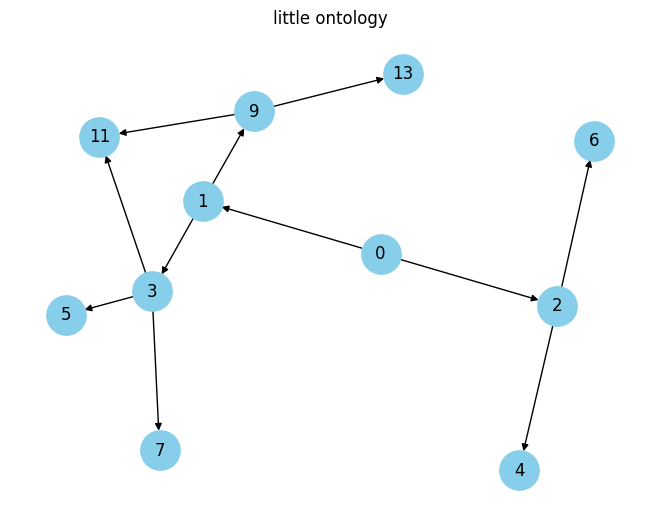

Retrieving ancestors of each leaf: 100%|██████████| 4/4 [00:00<00:00, 30840.47it/s]


In [ ]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)
LO_edges = LO_edge_index.t().tolist()

# Initialize the ontology with the specified edges and display the graph
LO = init_ontology(LO_edges, display_output=True, output_name = "little ontology")
LO_leaves_ancestors = get_leaves_and_ancestors(LO_nx)


In [ ]:
type(LO.graph)

networkx.classes.digraph.DiGraph

# Loading models

In [137]:
to_complex = torch.load('/home/ebutz/ESL2024/to_complex_model_entire.pth')
print(to_complex)

ComplEx(82249, num_relations=1162017, hidden_channels=1)


# Retrieving leaf-ancestor similarity 

In [91]:
def get_distance(graph, node1, node2):
    if node1 == node2:
        return int(0)
    else :
        return len(nx.bidirectional_shortest_path(graph, source = node1, target = node2))
    
def get_similarity(ontology, node1, node2):
    return ontology.similarity(node1,node2).lin

print(get_distance(GO_nx,30082,41338))
print(get_similarity(GO_ontology, 30082,41338))

4
0.6668789811396013


In [143]:
distances_and_similarities = pd.DataFrame(columns=['leaf','ancestor', 'distance', 'similarity', 'model_score'])

leaves, ancestors =  [], []

for _, (leaf, leaf_ancestors) in enumerate(GO_leaves_ancestors.items()):
     for leaf_ancestor in leaf_ancestors:
        leaves.append(leaf)
        ancestors.append(leaf_ancestor)

distances_and_similarities['leaf']= leaves
distances_and_similarities['ancestor']= ancestors

tqdm.pandas(desc='Calculating leaves-ancestors distances')
distances_and_similarities['distance'] = distances_and_similarities.progress_apply(lambda row: get_distance(GO_nx, row['leaf'], row['ancestor']), axis=1)

# tqdm.pandas(desc='Calculating leaves_ancestos similarities')
# distances_and_similarities['similarity'] = distances_and_similarities.progress_apply(lambda row: get_similarity(GO_ontology, row['leaf'], row['ancestor']), axis=1)

display(distances_and_similarities)

Calculating leaves-ancestors distances: 100%|██████████| 324799/324799 [00:04<00:00, 71536.52it/s]


,leaf,ancestor,distance,similarity,model_score
0,30082,40098,2,NaN,NaN
1,30082,30082,0,NaN,NaN
2,30082,15386,6,NaN,NaN
3,30082,19439,5,NaN,NaN
4,30082,10098,6,NaN,NaN
...,...,...,...,...,...
324794,3928,25182,3,NaN,NaN
324795,3928,20067,3,NaN,NaN
324796,3928,14052,2,NaN,NaN
324797,3928,10098,5,NaN,NaN


In [146]:
distances_and_similarities = distances_and_similarities[distances_and_similarities.distance != 0]
distances_and_similarities

,leaf,ancestor,distance,similarity,model_score
0,30082,40098,2,NaN,NaN
2,30082,15386,6,NaN,NaN
3,30082,19439,5,NaN,NaN
4,30082,10098,6,NaN,NaN
5,30082,21843,5,NaN,NaN
...,...,...,...,...,...
324794,3928,25182,3,NaN,NaN
324795,3928,20067,3,NaN,NaN
324796,3928,14052,2,NaN,NaN
324797,3928,10098,5,NaN,NaN


# Comparing ontologies comprehension of the trained models

In [157]:
isa_id = 1

heads     = torch.Tensor(distances_and_similarities['leaf'].values).to(torch.long)
relations = torch.Tensor([isa_id]*heads.shape[0]).to(torch.long)
tails     = torch.Tensor(distances_and_similarities['ancestor'].values).to(torch.long)
print(heads, relations, tails)

tensor([30082, 30082, 30082,  ...,  3928,  3928,  3928]) tensor([1, 1, 1,  ..., 1, 1, 1]) tensor([40098, 15386, 19439,  ..., 14052, 10098, 11634])


In [158]:
scores = to_complex(heads, relations, tails)

distances_and_similarities['model_score'] = scores.tolist()
display(distances_and_similarities)

,leaf,ancestor,distance,similarity,model_score
0,30082,40098,2,NaN,0.007652
2,30082,15386,6,NaN,-0.002908
3,30082,19439,5,NaN,-0.002033
4,30082,10098,6,NaN,-0.001828
5,30082,21843,5,NaN,-0.002140
...,...,...,...,...,...
324794,3928,25182,3,NaN,0.000099
324795,3928,20067,3,NaN,0.000661
324796,3928,14052,2,NaN,0.000325
324797,3928,10098,5,NaN,0.000260


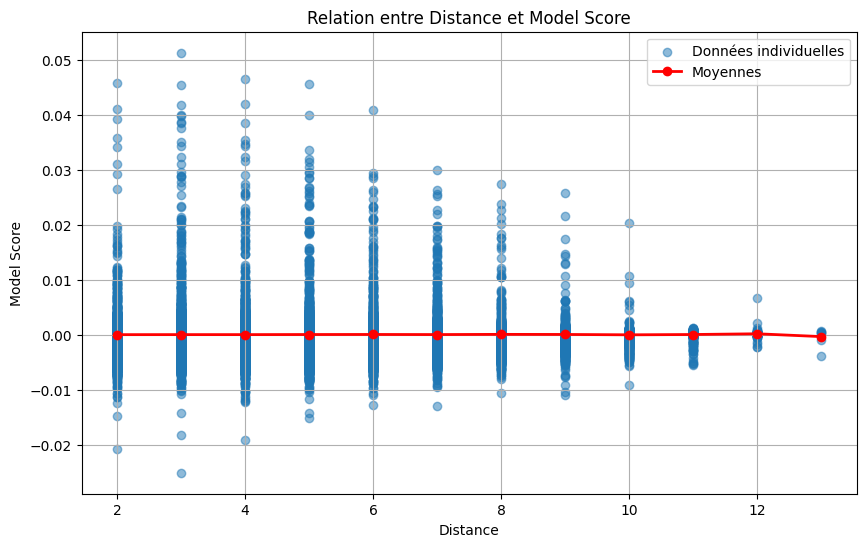

In [173]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Supposons que le DataFrame est déjà chargé dans distances_and_similarities

# Calculer la moyenne de model_score pour chaque valeur de distance
mean_scores = distances_and_similarities.groupby('distance')['model_score'].mean().reset_index()

# Scatter plot initial
plt.figure(figsize=(10, 6))
plt.scatter(distances_and_similarities['distance'], distances_and_similarities['model_score'], alpha=0.5, label='Données individuelles')

# Ajouter les valeurs moyennes
plt.plot(mean_scores['distance'], mean_scores['model_score'], color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Moyennes')

# Calculer la droite de tendance
slope, intercept = np.polyfit(distances_and_similarities['distance'], distances_and_similarities['model_score'], 1)
trendline = slope * distances_and_similarities['distance'] + intercept

# # Ajouter la droite de tendance
# plt.plot(distances_and_similarities['distance'], trendline, color='blue', linestyle='--', linewidth=2, label='Droite de tendance')

# Titre et labels
plt.title('Relation entre Distance et Model Score')
plt.xlabel('Distance')
plt.ylabel('Model Score')
plt.grid(True)
plt.legend()
plt.show()


In [174]:
correlation, p_value = pearsonr(distances_and_similarities['distance'], distances_and_similarities['model_score'])
print(f"Correlation de Pearson: {correlation}")
print(f"P-value: {p_value}")

Correlation de Pearson: 0.009141110830692974
P-value: 6.075220585438794e-07
